In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1) * np.dot(d2, d2) ) )

In [3]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [4]:
def box_extraction(img):
    (thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255-img_bin
    kernel_length = np.array(img).shape[1]//40
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    #cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    #cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #cv2.imwrite("img_final_bin.jpg",img_final_bin)
    contours, hierarchy = cv2.findContours(
        img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

    boxes = list()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cnt_len = cv2.arcLength(cnt, True)
        cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
        if len(cnt) == 4 and cv2.contourArea(cnt) > 500 and cv2.isContourConvex(cnt):
            cnt = cnt.reshape(-1, 2)
            max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
            if max_cos < 0.1:
                new_img = img[y:y+h, x:x+w]
                boxes.append(new_img)
    return boxes

In [5]:
def load_data(name):
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    result = box_extraction(image)
    for i, e in enumerate(result):
        result[i] = cv2.resize(e, (32,32))
    return result

In [6]:
plus = load_data('plus1.jpg') + load_data('plus2.jpg') + load_data('plus3.jpg')
check =  load_data('check1.jpg') + load_data('check2.jpg') + load_data('check3.jpg')
print(len(plus))
print(len(check))
slise = 2 * (len(plus) // 3)
x_train = np.array(plus[0:slise] + check[0:slise])
x_test = np.array(plus[(slise+1):len(plus)] + check[(slise+1):len(check)])
y_train = np.array(([0]*slise + [1]*slise)).astype('uint8')
y_test = np.array(([0]*(len(plus)-slise-1) + [1]*(len(check)-slise-1))).astype('uint8')

288
288


In [7]:
x_train, y_train = shuffle(x_train, y_train)
x_train = x_train / 255.0
x_test  = x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1).astype('float32')



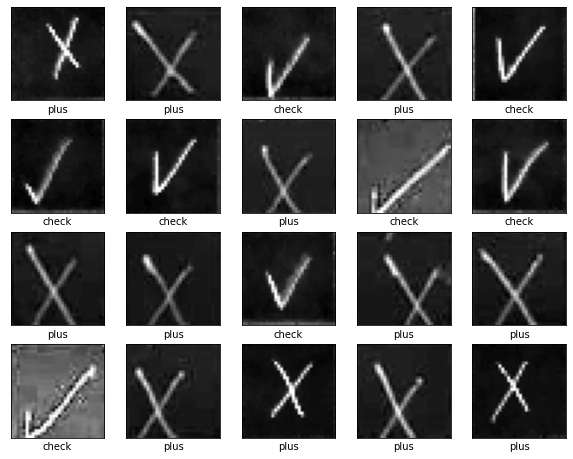

In [8]:
class_names = [ 'plus','check']
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_train[i]), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [9]:
dense_model_1 = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(32, 32, 1)),
          tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
dense_model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [10]:
dense_model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(1024, activation=tf.nn.softmax),
    tf.keras.layers.Dense(2,  activation=tf.nn.softmax)
])
dense_model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [11]:
convolutional_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(9, (5, 5), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(30, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
convolutional_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
dense_model_1.fit(x=x_train, y=y_train, epochs=30)

Epoch 1/30
12/12 [==============================] - 0s 661us/step - loss: 0.8267 - accuracy: 0.4818
Epoch 2/30
12/12 [==============================] - 0s 951us/step - loss: 0.7061 - accuracy: 0.5365
Epoch 3/30
12/12 [==============================] - 0s 829us/step - loss: 0.6836 - accuracy: 0.5286
Epoch 4/30
12/12 [==============================] - 0s 703us/step - loss: 0.6266 - accuracy: 0.6484
Epoch 5/30
12/12 [==============================] - 0s 703us/step - loss: 0.5986 - accuracy: 0.6562
Epoch 6/30
12/12 [==============================] - 0s 744us/step - loss: 0.5957 - accuracy: 0.6823
Epoch 7/30
12/12 [==============================] - 0s 951us/step - loss: 0.5709 - accuracy: 0.7005
Epoch 8/30
12/12 [==============================] - 0s 785us/step - loss: 0.5459 - accuracy: 0.7865
Epoch 9/30
12/12 [==============================] - 0s 661us/step - loss: 0.5331 - accuracy: 0.7474
Epoch 10/30
12/12 [==============================] - 0s 785us/step - loss: 0.5110 - accuracy: 0.8073

In [13]:
dense_model_1.evaluate(x_test, y_test)

6/6 [==============================] - 0s 744us/step - loss: 0.3777 - accuracy: 0.9895


[0.3777267336845398, 0.9894737005233765]

In [14]:
dense_model_2.fit(x=x_train, y=y_train, epochs=30)

Epoch 1/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4844
Epoch 2/30
12/12 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5078
Epoch 3/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5964
Epoch 4/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.6797
Epoch 5/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.7109
Epoch 6/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.6875
Epoch 7/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.7995
Epoch 8/30
12/12 [==============================] - 0s 5ms/step - loss: 0.6532 - accuracy: 0.8490
Epoch 9/30
12/12 [==============================] - 0s 5ms/step - loss: 0.6407 - accuracy: 0.8958
Epoch 10/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.9375
Epoch 11/30
12/12 [

In [15]:
dense_model_2.evaluate(x_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 1.0000


[0.4450799524784088, 1.0]

In [16]:
convolutional_model.fit(x=x_train, y=y_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 0s 8ms/step - loss: 0.6593 - accuracy: 0.5495
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.5172 - accuracy: 0.8828
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.3210 - accuracy: 0.9115
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 0.1901 - accuracy: 0.9583
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.1170 - accuracy: 0.9740
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0805 - accuracy: 0.9792
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0798 - accuracy: 0.9740
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9766
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9870
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9818
Epoch 11/

In [17]:
convolutional_model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9105


[0.18946382403373718, 0.9105263352394104]